In [1]:
!nvidia-smi

Tue Sep 26 01:12:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650       WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P8                4W /  N/A|    267MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import Neccessary Libraries

In [2]:
import os
import random
from collections import namedtuple
import time
import math
import pandas as pd
import numpy  as np
import cv2
from PIL import Image


# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from skimage.feature import local_binary_pattern

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import cycle
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import Normalize

from sklearn import svm
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

# for splitting the images into train/ test/val folder
import splitfolders

c:\Users\kings\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define seed to eneable reproducibility of results
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
folders = os.listdir(r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer_mediapipe\fer_train_val_test\train")

In [5]:
# Check the size of the data
train_total = []
val_total = []
for folder in folders:
  train_dir = r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer_mediapipe\fer_train_val_test\train"
  train_total.append(len(os.listdir(train_dir + "\\" + folder)))
    
  val_dir = r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer_mediapipe\fer_train_val_test\val"
  val_total.append(len(os.listdir(val_dir + "\\" + folder)))
print(f"Train Images--------- {sum(train_total)}\nValidation Images----------------- {sum(val_total)}")

test_dir = r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer_mediapipe\fer_train_val_test\test\Unknown"
print(f"Test Images----------- {len(os.listdir(test_dir))}")
print("")
print(f"Total number of Images: {sum(train_total) + sum(val_total) + (len(os.listdir(test_dir)))}")

Train Images--------- 20033
Validation Images----------------- 2856
Test Images----------- 5739

Total number of Images: 28628


In [6]:
batch_size = 32
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    
    # Standardize each channel of the image
    transforms.Normalize([0.4629, 0.4715, 0.4714],
                          [0.2427, 0.2457, 0.2448])
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4629, 0.4715, 0.4714],
                          [0.2427, 0.2457, 0.2448])
   ])

# Load the datatsets from each folder

In [7]:
data_dir = r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer_mediapipe"

train = datasets.ImageFolder(
    os.path.join(data_dir, 'fer_train_val_test', 'train'),
    transform=transform_train)

In [8]:
val, test = [datasets.ImageFolder(
    os.path.join(data_dir, 'fer_train_val_test', folder),
    transform=transform_test) for folder in ['val', 'test']]

In [9]:
train_iter = data.DataLoader(train, batch_size, shuffle=True, drop_last=True)

valid_iter = data.DataLoader(val, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = data.DataLoader(test, batch_size, shuffle=False,
                                        drop_last=False)

### This is an additional code to check the mean and standard deviation of your dataset - you can then use it to replace the values in transforms.Normalize to improve your work

In [10]:
# means = torch.zeros(3)
# stds = torch.zeros(3)

# for img, label in train:
#     means += torch.mean(img, dim = (1,2))
#     stds += torch.std(img, dim = (1,2))

# means /= len(train)
# stds /= len(train)
    
# print(f'Calculated means: {means}')
# print(f'Calculated stds: {stds}')

### Show image - display some of your images for observation.

In [11]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

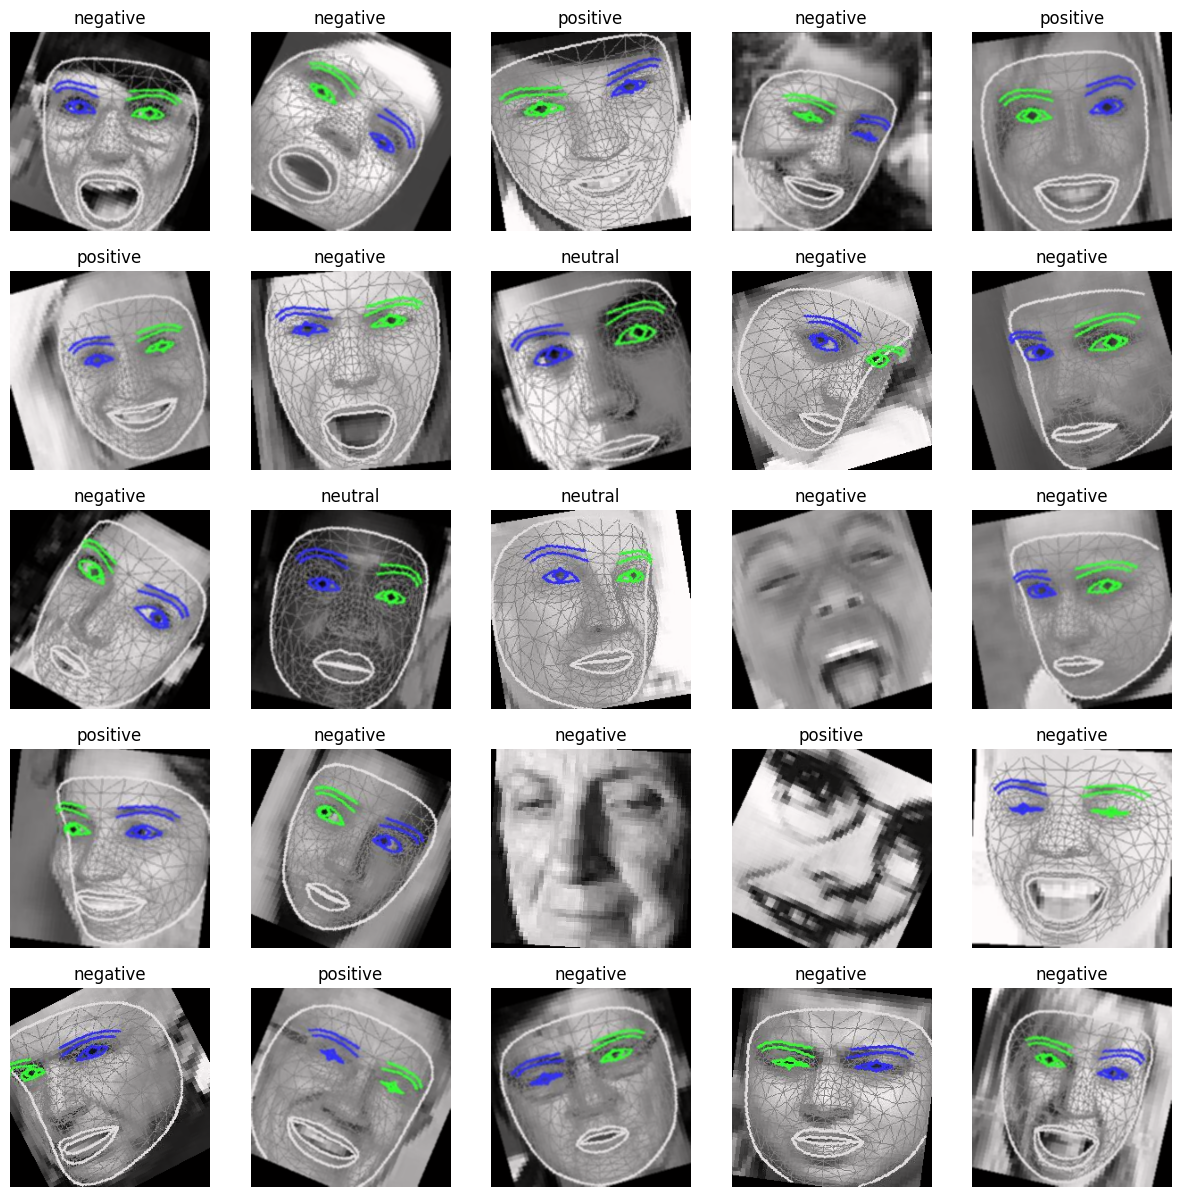

In [12]:
N_IMAGES = 25

images, labels = next(iter(train_iter))
image_label_pairs = list(zip(images, labels))
random.shuffle(image_label_pairs)
shuffled_images, shuffled_labels = zip(*image_label_pairs)
classes = train.classes

plot_images(shuffled_images[:N_IMAGES], shuffled_labels[:N_IMAGES], classes)

In [13]:
images[0].shape

torch.Size([3, 224, 224])

# Define Baseline Model
Using `resnet50()` as baseline model

In [14]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

### HERE you can start to define your model, you can use different resnet for your work.

In [15]:
pretrained_model = models.resnet50(pretrained = True)
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(train.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
resnet_model = ResNet(resnet50_config, OUTPUT_DIM)
resnet_model.load_state_dict(pretrained_model.state_dict())

c:\Users\kings\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kings\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [16]:
def count_parameters(model):
    return __builtins__.sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(resnet_model):,} trainable parameters')

The model has 23,514,179 trainable parameters


### Setting the hyperparameters and train the model

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
resnet_model = resnet_model.to(device)
criterion = criterion.to(device)

In [18]:
FOUND_LR = 2e-4

params = [
          {'params': resnet_model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': resnet_model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': resnet_model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': resnet_model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': resnet_model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': resnet_model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': resnet_model.fc.parameters()}
         ]

# different optimizers
adam_opt = optim.Adam(params, lr=FOUND_LR)
sgd = optim.SGD(params, lr=FOUND_LR)
sgd_nesterov_opt = optim.SGD(params, lr=FOUND_LR,momentum=0.9, nesterov=True)

#  First running the ResNet50 Model Using Adam optimizer 

In [19]:
def changeepochs(epochs, opt):
    STEPS_PER_EPOCH = len(train_iter)
    TOTAL_STEPS = epochs * STEPS_PER_EPOCH

    MAX_LRS = [p['lr'] for p in opt.param_groups]

    scheduler = lr_scheduler.OneCycleLR(opt,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)
    return scheduler

In [20]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [21]:
def train_model(model, iterator, optimizer, criterion, device, scheduler=None ):
    
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        if scheduler:
            scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
        
    return epoch_loss, epoch_acc

In [22]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0

    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
        
    return epoch_loss, epoch_acc

In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
scheduler = changeepochs(20, adam_opt)

In [25]:
def run_model(EPOCHS, model, opt, scheduler=None):
    counter = 0
    patience = 10
    best_valid_loss = float('inf')
    best_epoch = 0
    best_val_acc = float('inf')
    train_accs = []
    valid_accs = []
    train_losses = []
    valid_losses = []
    for epoch in range(EPOCHS):        
        start_time = time.monotonic()
        if scheduler:
            train_loss, train_acc = train_model(model, train_iter, opt, criterion, device, scheduler)
            valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_val_acc = valid_acc
                best_epoch = epoch
                filename = fr"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\models\{model.__class__.__name__}_{opt.__class__.__name__}Aug_mediapipe.pt"
                torch.save(model.state_dict(), filename)
                counter = 0
            else:
                counter += 1  # increase patience counter on no improvement
                if counter >= patience:
                    print(f"Validation loss hasn't improved in {patience} epochs. Stopping early.")
                    break
        else:
            train_loss, train_acc = train_model(model, train_iter, opt, criterion, device)
            valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_val_acc = valid_acc
                best_epoch = epoch
                filename = fr"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\models\{model.__class__.__name__}_{opt.__class__.__name__}Aug_mediapipe.pt"
                torch.save(model.state_dict(), filename)
                counter = 0
            else:
                counter += 1  # increase patience counter on no improvement
                if counter >= patience:
                    print(f"Validation loss hasn't improved in {patience} epochs. Stopping early.")
                    break

        

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}% |")
        print(f"\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}% |")
    print(f"best epcoh: {best_epoch+1}, best _validation accuracy: {best_val_acc}, best Validation loss: {best_valid_loss}")
    return train_accs, valid_accs, train_losses, valid_losses

In [26]:
train_accs, valid_accs, train_losses, valid_losses = run_model(20, resnet_model, adam_opt, scheduler)

Epoch: 01 | Epoch Time: 10m 30s
	Train Loss: 0.815 | Train Acc:  63.35% |
	Valid Loss: 0.648 | Valid Acc:  71.42% |
Epoch: 02 | Epoch Time: 9m 52s
	Train Loss: 0.604 | Train Acc:  73.71% |
	Valid Loss: 0.569 | Valid Acc:  76.26% |
Epoch: 03 | Epoch Time: 9m 45s
	Train Loss: 0.545 | Train Acc:  76.87% |
	Valid Loss: 0.535 | Valid Acc:  77.35% |
Epoch: 04 | Epoch Time: 9m 52s
	Train Loss: 0.506 | Train Acc:  78.73% |
	Valid Loss: 0.519 | Valid Acc:  77.91% |
Epoch: 05 | Epoch Time: 9m 32s
	Train Loss: 0.465 | Train Acc:  80.37% |
	Valid Loss: 0.501 | Valid Acc:  78.62% |
Epoch: 06 | Epoch Time: 9m 28s
	Train Loss: 0.441 | Train Acc:  81.70% |
	Valid Loss: 0.479 | Valid Acc:  79.99% |
Epoch: 07 | Epoch Time: 9m 28s
	Train Loss: 0.406 | Train Acc:  83.11% |
	Valid Loss: 0.457 | Valid Acc:  80.62% |
Epoch: 08 | Epoch Time: 9m 35s
	Train Loss: 0.379 | Train Acc:  84.23% |
	Valid Loss: 0.463 | Valid Acc:  81.74% |
Epoch: 09 | Epoch Time: 9m 39s
	Train Loss: 0.350 | Train Acc:  85.74% |
	Valid

In [29]:
def plot_loss_acc():
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].plot(train_losses, label='Training Loss')
    ax[0].plot(valid_losses, label='Validation Loss')
    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_title("Train vs Validation Loss", weight="bold")
    ax[0].legend()

    ax[1].plot(train_accs, label='Training Accuracy')
    ax[1].plot(valid_accs, label='Validation Accuracy')
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[1].set_title("Train vs Validation Accuracy", weight="bold")
    ax[1].legend();
    plt.show()

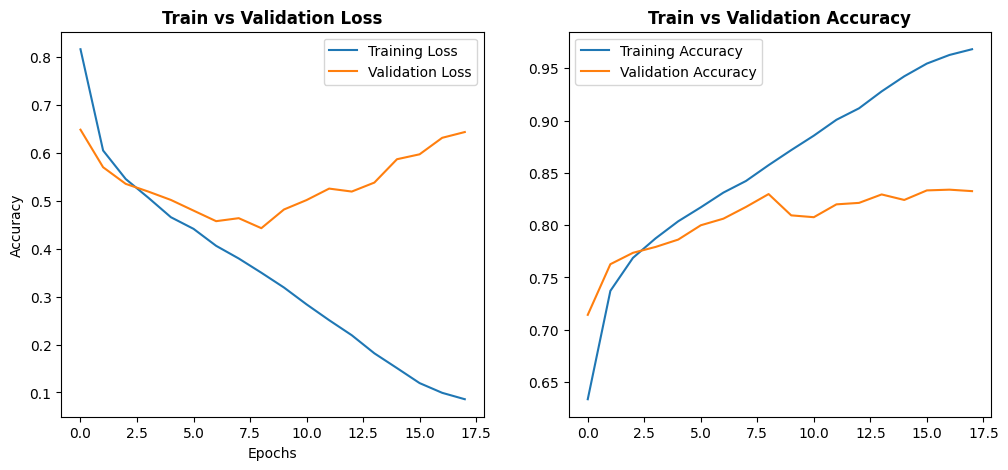

In [30]:
plot_loss_acc()

In [15]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [16]:
from scipy import interp
def plot_roc_curves(y_test, probs, class_labels):
    n_classes = len(class_labels)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    for i, label in enumerate(class_labels):
        plt.plot(fpr[i], tpr[i], lw=lw,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(label, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves of Proposed Method')
    plt.legend(loc="lower right")
    plt.show()


In [17]:
# Load the saved state dictionary
state_dict = torch.load(r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\models\ResNet_AdamAug_mediapipe.pt")
resnet_model = ResNet(resnet50_config, 3)
# Replace the model's state dictionary with the saved state dictionary
resnet_model.load_state_dict(state_dict)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model = resnet_model.to(device)
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
images, labels, probs = get_predictions(resnet_model, test_iter)

In [19]:
test = pd.read_csv(r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer\fer_train_val_test\GroundTruth.csv")
y_test = np.array(test.drop(['id'], axis=1))
pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)
class_names = unique_labels(true_class, pred_class)

In [20]:
test.columns

Index(['id', 'negative', 'neutral', 'positive'], dtype='object')

In [21]:
class_names

array([0, 1, 2], dtype=int64)

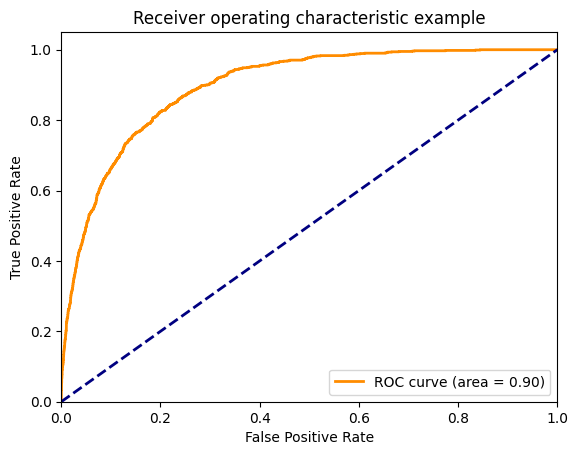

C:\Users\kings\AppData\Local\Temp\ipykernel_13784\3032910195.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


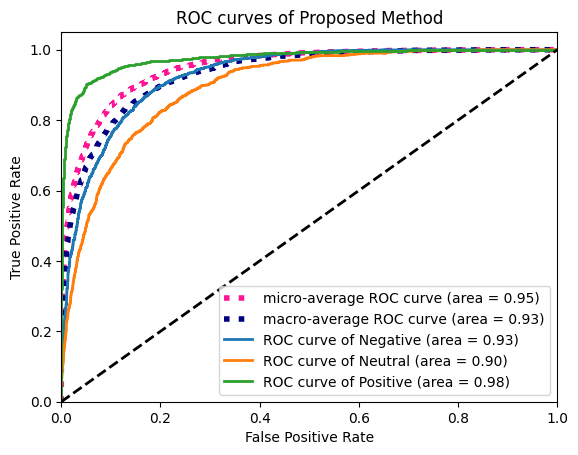

In [22]:
class_dict = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
class_names = [class_dict[label] for label in class_names]
plot_roc_curves(y_test, probs, class_names)

In [23]:
def plot_cm_class_report():
    cm=confusion_matrix(true_class, pred_class)
    class_names = unique_labels(true_class, pred_class)
    class_dict = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    class_names = [class_dict[label] for label in class_names]
    print(cm)
    print(class_names)

    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)

    C = cm
    divisor = np.zeros((3,3))
    divisor[0][:] = 2745
    divisor[1][:] = 1001
    divisor[2][:] = 1755
    cm_normalised=np.divide(cm, divisor)
    print(np.transpose(C.sum(axis=1)))
    print(divisor)
    cm_normalised = np.round(cm_normalised, 2)
    disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='');
    print(classification_report(true_class, pred_class))

[[2465  333  114]
 [ 299  642   74]
 [ 137   69 1606]]
['Negative', 'Neutral', 'Positive']
[2912 1015 1812]
[[2745. 2745. 2745.]
 [1001. 1001. 1001.]
 [1755. 1755. 1755.]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2912
           1       0.61      0.63      0.62      1015
           2       0.90      0.89      0.89      1812

    accuracy                           0.82      5739
   macro avg       0.79      0.79      0.79      5739
weighted avg       0.82      0.82      0.82      5739



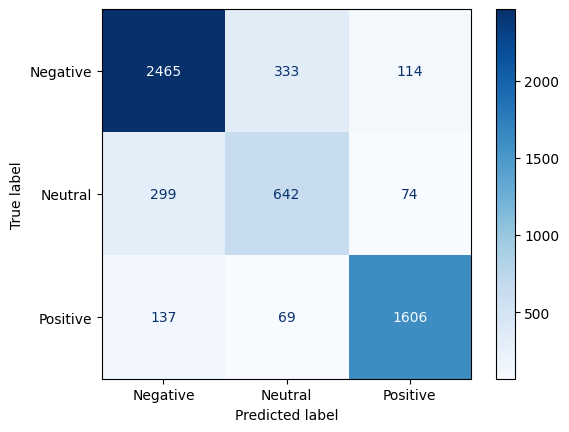

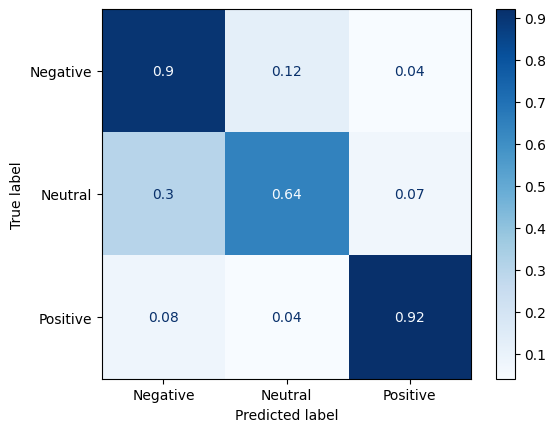

In [24]:
plot_cm_class_report()

In [25]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.6)

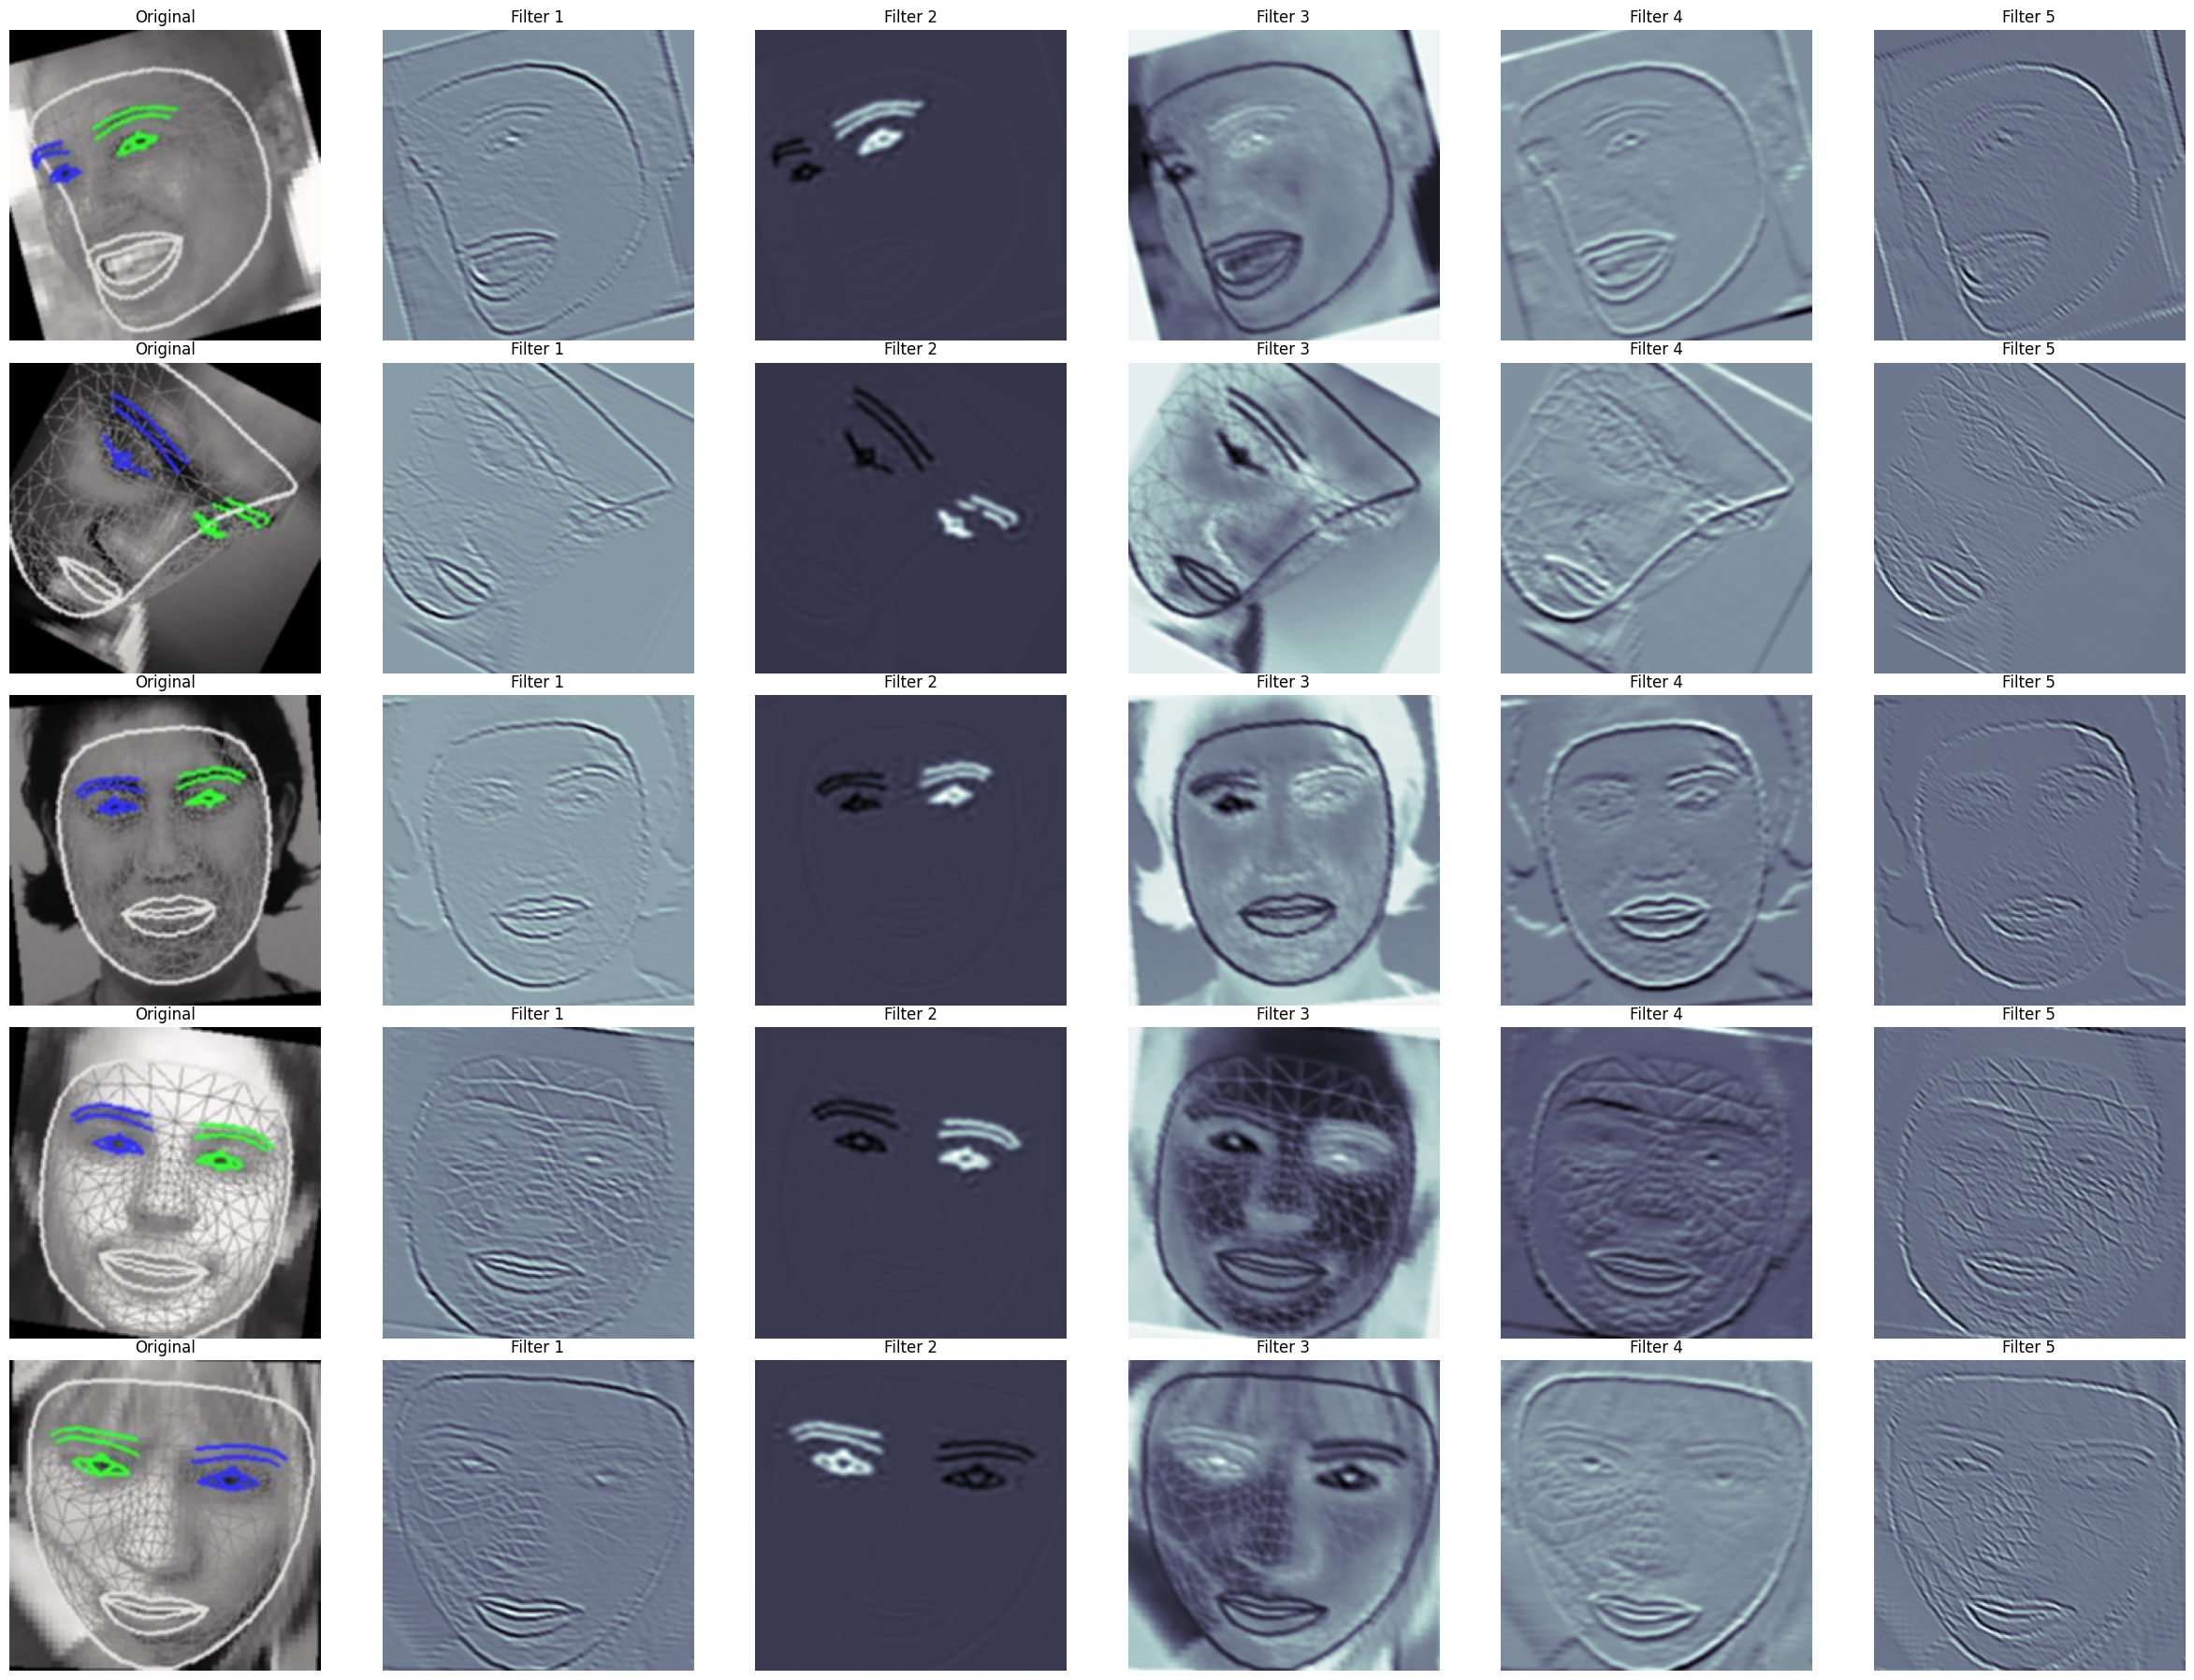

: 

In [27]:
N_IMAGES = 5
N_FILTERS = 5


images, labels = next(iter(train_iter))
image_label_pairs = list(zip(images, labels))
random.shuffle(image_label_pairs)
shuffled_images, shuffled_labels = zip(*image_label_pairs)
classes = train.classes

images = [image for image, label in [train[i] for i in range(N_IMAGES)]]
filters = resnet_model.conv1.weight.data
plot_filtered_images(shuffled_images[:N_IMAGES], filters, N_FILTERS)